I have used a tool called ogr2ogr to convert the original json

with uses coordinates with WGS84(EPSG:4326) to projection (EPSG:31983)

Commands: ogr2ogr -f "GeoJSON" -t_srs "EPSG:31983" sergipeEPSG31983.geojson sergipe.json 

Github of the original JSON: https://github.com/giuliano-macedo/geodata-br-states

EPSG:4326: https://epsg.io/4326

EPSG:31983: https://epsg.io/31983

Import the necessary library's

In [266]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Extract the points from the geojson

In [267]:
fileName = 'sergipeEPSG31983'
d = json.load(open(f"./{fileName}.geojson"))
points = d["features"][0]["geometry"]["coordinates"][0][0]


Generate the coordinates of Sergipe perimeter

In [268]:
OFFSET_X_WEIGHT = 1.34e6
OFFSET_Y_WEIGHT = 8.82e6
x = [point[0] - OFFSET_X_WEIGHT for point in points]
y = [point[1] - OFFSET_Y_WEIGHT for point in points]

Graph Configuration

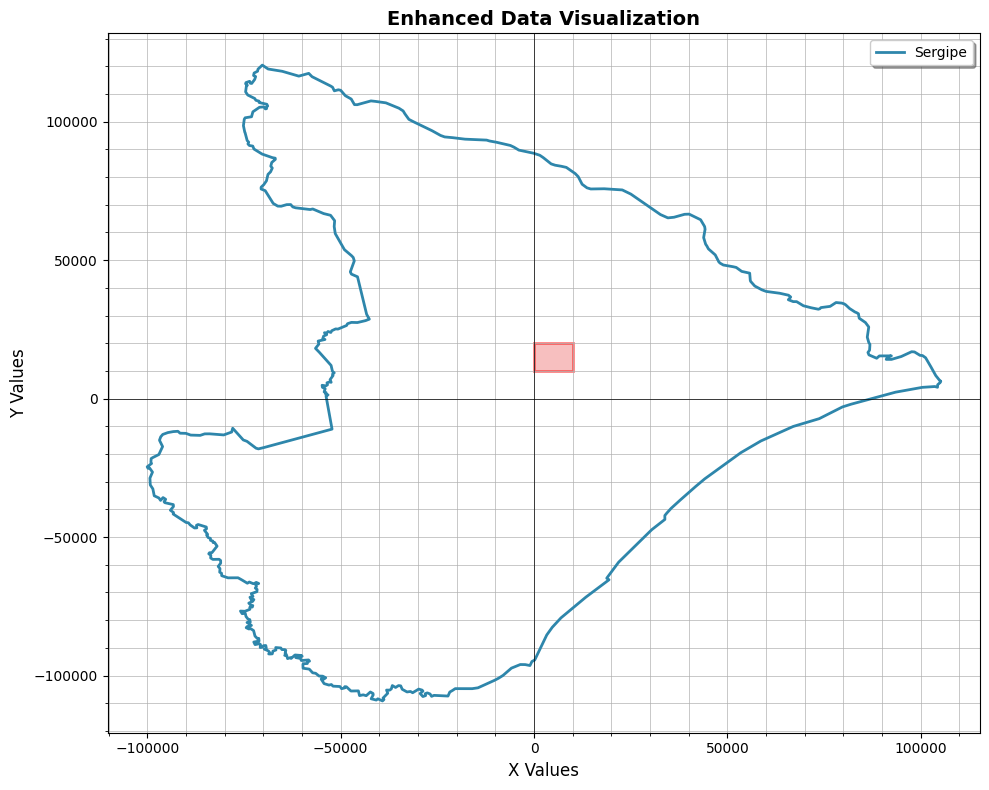

In [ ]:
# Create figure and axis with better size
fig, ax = plt.subplots(figsize=(10, 8))
line = ax.plot(x, y, linewidth=2, markersize=6, label='Sergipe', color='#2E86AB')
# Set up the grid with more divisions
ax.grid(True, which='both', linestyle='-', linewidth=.7, alpha=0.7)
# Add minor grid lines for more divisions
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=.7, alpha=0.7)
# Add axes at (0,0)
ax.axhline(y=0, color='k', linewidth=.5)
ax.axvline(x=0, color='k', linewidth=.5)
# Add labels and title
ax.set_xlabel('X Values', fontsize=12)
ax.set_ylabel('Y Values', fontsize=12)
ax.set_title('Enhanced Data Visualization', fontsize=14, fontweight='bold')
# Add legend
ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=10)
# Adjust layout to prevent clipping
plt.tight_layout()
# Add red rectangle at (0, 0)
rect_width = 10000  # ajuste conforme necessário
rect_height = 10000  # ajuste conforme necessário
rectangle = Rectangle((0, rect_height), rect_width, rect_height, 
                      linewidth=2, edgecolor='red', 
                      facecolor='lightcoral', alpha=0.5)
ax.add_patch(rectangle)
# plot the graph
plt.show()